In [1]:
#import modules and set up environment 
import os
import sys
path = "../../src/"

sys.path.append(path)
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import jax.numpy as jnp
from jax import jit, grad, vmap, hessian, scipy, random

#import sgmcmc code 
import models.logistic_regression.logistic_regression as lr
import samplers.sgd as sgd
import samplers.sgld as sgldcv
import samplers.sgldps as sgldcvps

# plt.style.use('tableau-colorblind10')
plt.style.use('seaborn-colorblind')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

/opt/anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#load in the data
file_path = "../../data/synthetic/lr_balance_train_synth.csv"
data = pd.read_csv(file_path)
dat_array = data.values[:]
N = dat_array.shape[0]
x = dat_array[:, 1:]
y = dat_array[:,0]

#set up model parameters
dim = x.shape[1] 
Niter = 10**4
n_batch = 0.001*N

### Importing csv files

In [3]:
methods = ["sgldcv", "sgldcvps", "asgldcv", "asgldcvps"]
ksd = dict()
mse = dict()

for i in range(len(methods)):
    method = methods[i]
    items = glob.glob(f"./out/ksdlrb_{method}.csv")[0]
    ksd[method] = pd.read_csv(items)

### Plot KSD 

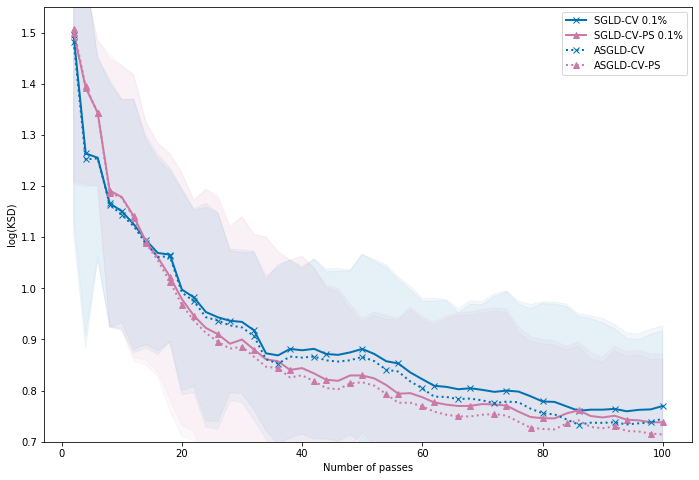

In [4]:
plot_methods = ["sgldcv", "sgldcvps", "asgldcv", "asgldcvps"]
labs = ["SGLD-CV 0.1%", "SGLD-CV-PS 0.1%", "ASGLD-CV", "ASGLD-CV-PS"] 
lines = ["-","-", "dotted", "dotted"]
markers = ["x", "^"]*2
col_idx = [0, 3]*2

samples_csv = dict()
Niter = 10**4
idx_sgld =np.arange(10000, 0, -200)[::-1]-1

fig, ax = plt.subplots(figsize=(12,8))
plt.gcf().subplots_adjust(left=0.15)


for i in range(0,4):
    plot_data = []
    method = plot_methods[i]
    plot_data.append((idx_sgld)*0.01)
    smooth_path    = ksd[method].mean(axis=1)
    plot_data.append(smooth_path)
    path_deviation = 2*ksd[method].std(axis=1)
    under_line     = (smooth_path-path_deviation)
    plot_data.append(under_line)
    over_line      = (smooth_path+path_deviation)
    plot_data.append(over_line) 
    dat = np.array(pd.DataFrame(plot_data).T)
    ax.plot(dat[:,0], dat[:, 1], linestyle = lines[i], label=labs[i], c = colors[col_idx[i]], marker=markers[i], markevery=0.05, linewidth=2)
    ax.fill_between(dat[:,0], dat[:, 2], dat[:, 3], color = colors[col_idx[i]],alpha=.05)

# plt.yscale("log")
#plt.xscale("log")  
plt.xlabel("Number of passes")
plt.ylabel("log(KSD)")
plt.ylim((0.7,1.55))
plt.legend()
plt.savefig("./fig/lr_ksd_casp_asgldcv.pdf")
plt.show()

### Plotting adaptive subsampling behaviour

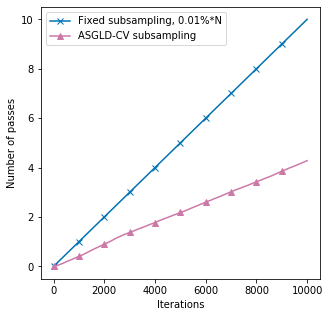

In [5]:
cv_n_df = pd.read_csv("./out/lrb_asgldcv_n.csv")
cumulative_n_adaptive = np.cumsum(cv_n_df.mean(axis=1))/N
cumulative_n = np.cumsum(np.array([n_batch]*Niter))/N

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(cumulative_n, label="Fixed subsampling, 0.01%*N", marker="x", markevery=1000,c=colors[0], linewidth=1.5)
plt.plot(cumulative_n_adaptive, label="ASGLD-CV subsampling", marker="^", markevery=1000,c=colors[3], linewidth=1.5)
plt.ylabel("Number of passes")
plt.xlabel("Iterations")
plt.legend()
plt.savefig("./fig/lr_npass_synth_asgldcv.pdf")
plt.show()

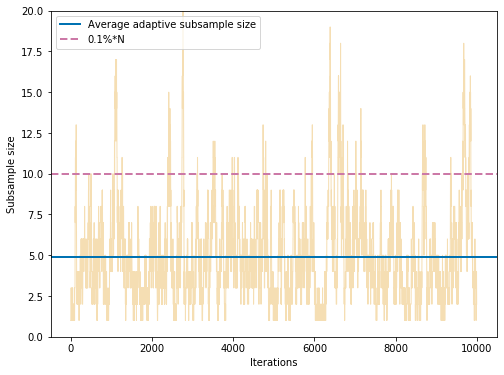

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
example_nvec = cv_n_df.values[:, 2]
plt.plot(example_nvec, c='wheat', linewidth=1)
plt.axhline(example_nvec.mean(), c=colors[0], label="Average adaptive subsample size", linewidth=2)
plt.axhline(n_batch, linestyle="dashed", c=colors[3], label="0.1%*N", linewidth=2)
plt.ylabel("Subsample size")
plt.xlabel("Iterations")
plt.ylim((0,20))
plt.legend()
plt.savefig("./fig/lrb_nvec_synth_asgldcv.pdf")
plt.show()

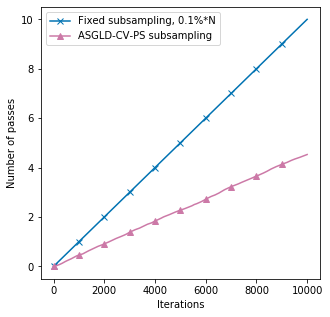

In [7]:
cvps_n_df = pd.read_csv("./out/lrb_asgldcvps_n.csv")
cumulative_n_adaptive = np.cumsum(cvps_n_df.mean(axis=1))/N
cumulative_n = np.cumsum(np.array([n_batch]*Niter))/N

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(cumulative_n, label="Fixed subsampling, 0.1%*N", marker="x", markevery=1000,c=colors[0], linewidth=1.5)
plt.plot(cumulative_n_adaptive, label="ASGLD-CV-PS subsampling", marker="^", markevery=1000,c=colors[3], linewidth=1.5)
plt.ylabel("Number of passes")
plt.xlabel("Iterations")
plt.legend()
plt.savefig("./fig/lr_npass_synth_asgldcvps.pdf")
plt.show()

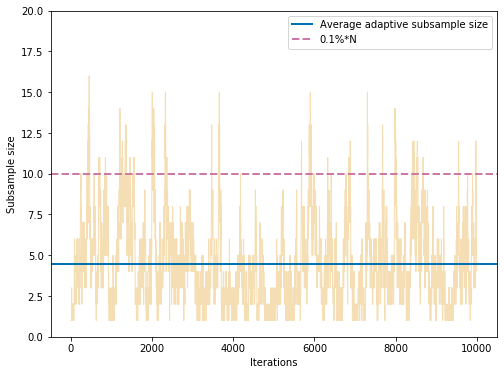

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

example_nvec = cvps_n_df.values[:, 2]
plt.plot(example_nvec, c='wheat', linewidth=1)
plt.axhline(example_nvec.mean(), c=colors[0], label="Average adaptive subsample size", linewidth=2)
plt.axhline(n_batch, linestyle="dashed", c=colors[3], label="0.1%*N", linewidth=2)
plt.ylabel("Subsample size")
plt.xlabel("Iterations")
plt.ylim((0,20))
plt.legend()
plt.savefig("./fig/lrb_nvec_synth_asgldcvps.pdf")
plt.show()